# Training Transformer

### TA's Slide
[Slide](https://docs.google.com/presentation/d/1ga0d43mWyrfHjdkp7FG3iWcEKTGr8CdkifYhhi4LBY8/edit?usp=sharing)

### Description
In this assignment, we are tasked with utilizing a transformer decoder-only architecture for pretraining, with a focus on next-token prediction, applied to Pokémon images.

Please feel free to mail us if you have any questions.

ntu-ml-2025-spring-ta@googlegroups.com

# Utilities

### Download packages

In [17]:
!pip install datasets==3.3.2

### Import Packages

In [18]:
import os
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.optim as optim
from PIL import Image
from torch import nn
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
from transformers import AutoModelForCausalLM, GPT2Config, set_seed
from datasets import load_dataset
from typing import Dict, Any, Optional

### Check Devices

In [19]:
!nvidia-smi

Thu Apr 10 07:06:24 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   57C    P0             28W /   70W |    1400MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

### Set Random Seed

In [20]:
set_seed(0)

# Prepare Data

### Define Dataset

In [21]:
from typing import List, Tuple, Union
import torch
from torch.utils.data import Dataset

class PixelSequenceDataset(Dataset):
    def __init__(self, data: List[List[int]], mode: str = "train"):
        """
        A dataset class for handling pixel sequences.

        Args:
            data (List[List[int]]): A list of sequences, where each sequence is a list of integers.
            mode (str): The mode of operation, either "train", "dev", or "test".
                - "train": Returns (input_ids, labels) where input_ids are sequence[:-1] and labels are sequence[1:].
                - "dev": Returns (input_ids, labels) where input_ids are sequence[:-160] and labels are sequence[-160:].
                - "test": Returns only input_ids, as labels are not available.
        """
        self.data = data
        self.mode = mode

    def __len__(self) -> int:
        """Returns the total number of sequences in the dataset."""
        return len(self.data)

    def __getitem__(self, idx: int) -> Union[Tuple[torch.Tensor, torch.Tensor], torch.Tensor]:
        """
        Fetches a sequence from the dataset and processes it based on the mode.

        Args:
            idx (int): The index of the sequence.

        Returns:
            - If mode == "train": Tuple[torch.Tensor, torch.Tensor] -> (input_ids, labels)
            - If mode == "dev": Tuple[torch.Tensor, torch.Tensor] -> (input_ids, labels)
            - If mode == "test": torch.Tensor -> input_ids
        """
        sequence = self.data[idx]

        if self.mode == "train":
            input_ids = torch.tensor(sequence[:-1], dtype=torch.long)
            labels = torch.tensor(sequence[1:], dtype=torch.long)
            return input_ids, labels

        elif self.mode == "dev":
            input_ids = torch.tensor(sequence[:-160], dtype=torch.long)
            labels = torch.tensor(sequence[-160:], dtype=torch.long)
            return input_ids, labels

        elif self.mode == "test":
            input_ids = torch.tensor(sequence, dtype=torch.long)
            return input_ids

        raise ValueError(f"Invalid mode: {self.mode}. Choose from 'train', 'dev', or 'test'.")

### Download Dataset & Prepare Dataloader

In [22]:
# Load the pokemon dataset from Hugging Face Hub
pokemon_dataset = load_dataset("lca0503/ml2025-hw4-pokemon")

# Load the colormap from Hugging Face Hub
colormap = list(load_dataset("lca0503/ml2025-hw4-colormap")["train"]["color"])

# Define number of classes
num_classes = len(colormap)

# Define batch size
batch_size = 16

# === Prepare Dataset and DataLoader for Training ===
train_dataset: PixelSequenceDataset = PixelSequenceDataset(
    pokemon_dataset["train"]["pixel_color"], mode="train"
)
train_dataloader: DataLoader = DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True
)

# === Prepare Dataset and DataLoader for Validation ===
dev_dataset: PixelSequenceDataset = PixelSequenceDataset(
    pokemon_dataset["dev"]["pixel_color"], mode="dev"
)
dev_dataloader: DataLoader = DataLoader(
    dev_dataset, batch_size=batch_size, shuffle=False
)

# === Prepare Dataset and DataLoader for Testing ===
test_dataset: PixelSequenceDataset = PixelSequenceDataset(
    pokemon_dataset["test"]["pixel_color"], mode="test"
)
test_dataloader: DataLoader = DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False
)

### Visualization

In [23]:
def pixel_to_image(pixel_color: List[int], colormap: List[List[int]]) -> Image.Image:
    """
    Converts a list of pixel indices into a 20x20 RGB image using a colormap.

    Args:
        pixel_color (List[int]): A list of pixel indices representing colors.
        colormap (List[List[int]]): A list where each index maps to an RGB color [R, G, B].

    Returns:
        Image.Image: A PIL Image object representing the reconstructed image.
    """
    # Ensure the pixel_color list has at least 400 elements (pad with 0s if needed)
    while len(pixel_color) < 400:
        pixel_color.append(0)

    # Map pixel indices to actual RGB colors using the colormap
    pixel_data = [colormap[pixel] for pixel in pixel_color]

    # Convert to numpy array and reshape to 20x20x3 (RGB image)
    image_array = np.array(pixel_data, dtype=np.uint8).reshape(20, 20, 3)

    # Create a PIL Image from the array
    image = Image.fromarray(image_array)

    return image

def show_images(images: List[Image.Image]) -> None:
    """
    Displays a grid of up to 96 images using Matplotlib.

    Args:
        images (List[Image.Image]): A list of PIL Image objects to display.

    Returns:
        None
    """
    num_images = min(96, len(images))  # Limit to 96 images

    # Set up the figure size and grid layout (6 rows, 16 columns)
    fig, axes = plt.subplots(6, 16, figsize=(16, 6))
    axes = axes.flatten()  # Flatten to make iteration easier

    # Loop through images and display each one in the grid
    for i, ax in enumerate(axes):
        if i < num_images:
            ax.imshow(images[i])
            ax.axis('off')  # Hide axis
        else:
            ax.axis('off')  # Hide unused subplots

    plt.tight_layout()  # Adjust layout to prevent overlap
    plt.show()

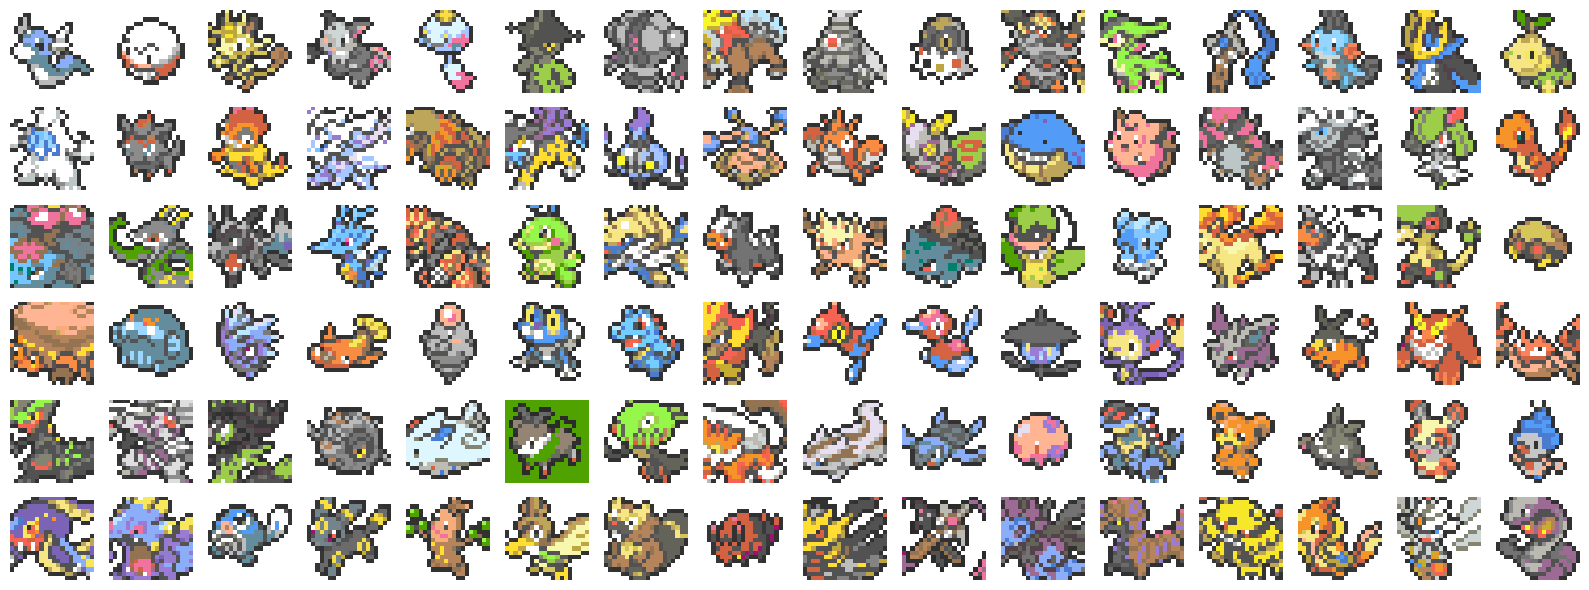

In [24]:
# Visualize train images
train_images = [pixel_to_image(data["pixel_color"], colormap) for data in pokemon_dataset["train"]]
show_images(train_images)

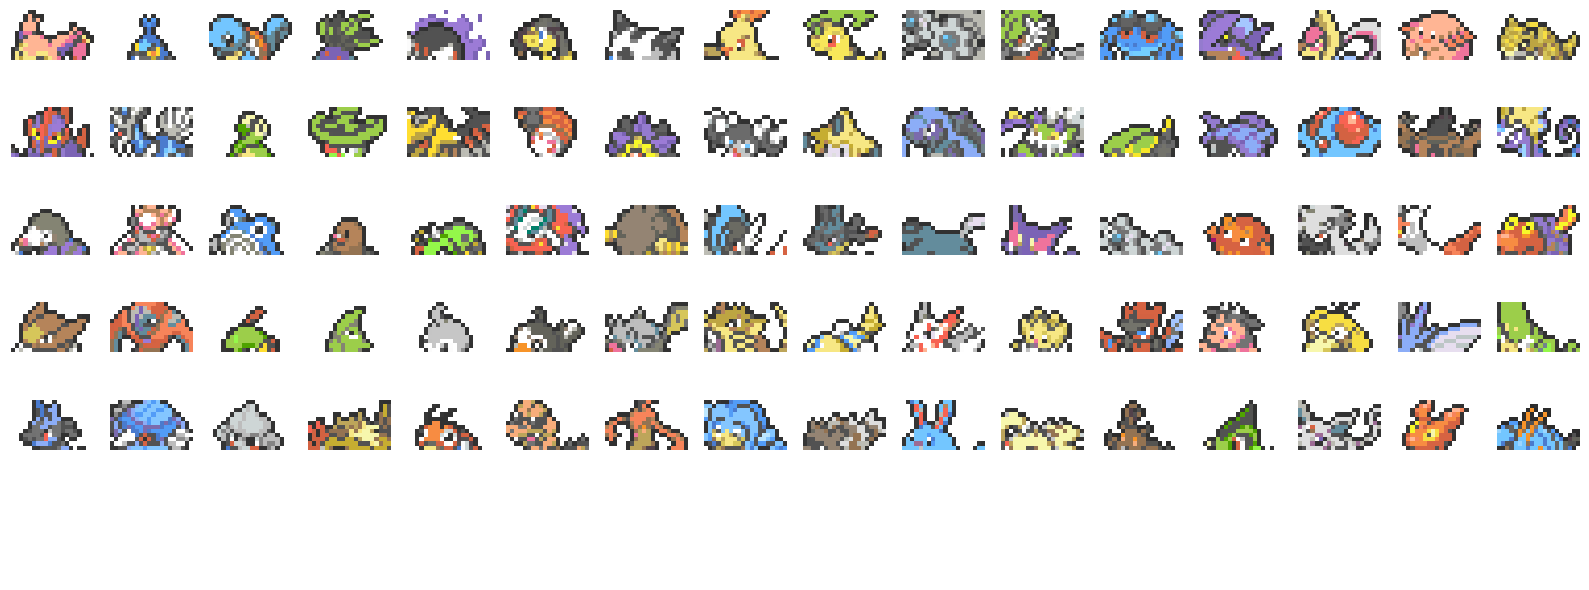

In [25]:
# Visualize test images
test_images = [pixel_to_image(data["pixel_color"], colormap) for data in pokemon_dataset["test"]]
show_images(test_images)

# Prepare Model

### Model Configuration
Here, we define the model configuration, including the architecture and key hyperparameters such as the number of attention heads, layers, embedding size, and more.
*   Hint 1: Adjust hyperparameters here for improved performance.
*   Hint 2: Experiment with different model architectures, such as Llama, Mistral, or Qwen, to enhance performance.
  * [LlamaConfig](https://huggingface.co/docs/transformers/model_doc/llama#transformers.LlamaConfig)
  * [MistralConfig](https://huggingface.co/docs/transformers/model_doc/mistral#transformers.MistralConfig)
  * [Qwen2Config](https://huggingface.co/docs/transformers/model_doc/qwen2#transformers.Qwen2Config)


In [26]:
from transformers import Qwen2Config, MistralConfig
# Define GPT-2 model configuration as a dictionary
gpt2_config = {
    "activation_function": "gelu_new",    # Activation function used in the model
    "architectures": ["GPT2LMHeadModel"],  # Specifies the model type
    "attn_pdrop": 0.1,            # Dropout rate for attention layers
    "embd_pdrop": 0.1,            # Dropout rate for embeddings
    "initializer_range": 0.02,        # Standard deviation for weight initialization
    "layer_norm_epsilon": 1e-05,       # Small constant to improve numerical stability in layer norm
    "model_type": "gpt2",           # Type of model
    "n_ctx": 128,               # Context size (maximum sequence length)
    "n_embd": 64,              # Embedding size
    "n_head": 2,               # Number of attention heads
    "n_layer": 2,              # Number of transformer layers
    "n_positions": 400,           # Maximum number of token positions
    "resid_pdrop": 0.1,           # Dropout rate for residual connections
    "vocab_size": num_classes,       # Number of unique tokens in vocabulary
    "pad_token_id": None,          # Padding token ID (None means no padding token)
    "eos_token_id": None,          # End-of-sequence token ID (None means not explicitly defined)
}
mistral_config = {
    "architectures": ["MistralForCausalLM"],  # Model class
    "model_type": "mistral",                  # Model identifier
    "hidden_size": 256,                        # Equivalent to n_embd
    "intermediate_size": 1024,                 # Feedforward size (usually 4x hidden_size)
    "num_attention_heads": 4,                 # Equivalent to n_head
    "num_hidden_layers": 5,                   # Equivalent to n_layer
    "max_position_embeddings": 400,           # Equivalent to n_positions
    "rms_norm_eps": 1e-05,                    # Equivalent to layer_norm_epsilon
    "vocab_size": num_classes,                # Vocabulary size
    "attention_dropout": 0.1,                 # Matches attn_pdrop
    "hidden_dropout": 0.1,                    # Matches embd_pdrop and resid_pdrop
    "initializer_range": 0.02,
    "rope_theta": 10000.0,                    # Standard RoPE base
    "rope_scaling": None,                     # Disable RoPE scaling
    "sliding_window": 128,                    # Equivalent to n_ctx
    "tie_word_embeddings": False,
    "pad_token_id": None,
    "eos_token_id": None,
    "use_cache": True,
    "hidden_act": "silu",                     # Mistral typically uses SiLU; no gelu/gelu_new in original
}

# Load GPT-2 model configuration from dictionary
config = GPT2Config.from_dict(mistral_config)

### Load Model

In [27]:
# Load the model using the configuration defined above
model = AutoModelForCausalLM.from_config(config)

print(model)

# Count trainable parameters
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Trainable Parameters: {trainable_params:,}")

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(167, 256)
    (wpe): Embedding(400, 256)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-4): 5 x GPT2Block(
        (ln_1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D(nf=768, nx=256)
          (c_proj): Conv1D(nf=256, nx=256)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=1024, nx=256)
          (c_proj): Conv1D(nf=256, nx=1024)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=256, out_features=167, bias=False)
)
Trainable Parameters: 4,137,216


# Train and Inference

### Training Arguments
Here, we define the number of epochs for training, the learning rate, the optimizer, and the loss function.
*   Hint 3: Adjust the number of epochs and learning rate here to improve performance.

In [28]:
# Training Parameters
epochs = 170                                      # Number of training epochs
learning_rate = 1e-4                               # Learning rate for optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")     # Check if CUDA is available for GPU
save_dir = "checkpoints"                               # Directory to save model checkpoints

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()                          # Loss function for classification tasks
optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=0.1) # AdamW optimizer with weight decay

### Save Model Function

In [29]:
def save_model(model: torch.nn.Module, optimizer: torch.optim.Optimizer, epoch: int, loss: float, save_dir: str, filename: str = "best_model.pth") -> None:
    """
    Saves the model state, optimizer state, current epoch, and loss to a specified directory.

    Args:
        model (torch.nn.Module): The PyTorch model to be saved.
        optimizer (torch.optim.Optimizer): The optimizer whose state will be saved.
        epoch (int): The current epoch number (used for checkpointing).
        loss (float): The current loss value to track model performance.
        save_dir (str): The directory where the model checkpoint will be saved.
        filename (str, optional): The name of the file to save the model. Defaults to "best_model.pth".

    Returns:
        None
    """
    # Construct the full path for saving the model checkpoint
    save_path = os.path.join(save_dir, filename)

    # Save the model, optimizer state, and additional metadata (epoch and loss)
    torch.save({
        'epoch': epoch + 1,                # Save epoch + 1 for easier tracking
        'model_state_dict': model.state_dict(),       # Save model weights
        'optimizer_state_dict': optimizer.state_dict(),  # Save optimizer state (important for resuming training)
        'loss': loss                     # Save the current loss value
    }, save_path)

    # Print a confirmation message indicating the model has been saved
    print(f"Model saved at {save_path} (Loss: {loss:.4f}, Epoch: {epoch + 1})")

### Train

We save the checkpoint with the lowest training loss since validation set reconstruction accuracy doesn't directly reflect the model's image generation quality.
*   Hint 4: Train a classifier to check if an image looks like a Pokémon or not. (Optional)

In [30]:
# Create save directory if it doesn't exist
os.makedirs(save_dir, exist_ok=True)
# Initialize best loss as positive infinity for comparison during model checkpointing
best_loss: float = float('inf')
# Move model to the appropriate device (GPU or CPU)
model.to(device)

# Training Loop
for epoch in range(epochs):
    model.train()  # Set the model to training mode
    epoch_loss = 0  # Initialize the epoch loss

    # Iterate over training data batches
    for input_ids, labels in tqdm(train_dataloader, desc=f"Training Epoch {epoch + 1}/{epochs}"):
        input_ids, labels = input_ids.to(device), labels.to(device)  # Move data to the same device as the model

        # Forward pass through the model to get logits (output probabilities)
        outputs = model(input_ids=input_ids).logits.view(-1, config.vocab_size)
        labels = labels.view(-1)  # Flatten labels to match logits shape

        # Calculate loss using CrossEntropyLoss
        loss = criterion(outputs, labels)

        # Backpropagation and optimizer step
        optimizer.zero_grad()  # Reset gradients to zero
        loss.backward()     # Compute gradients
        optimizer.step()     # Update model weights

        # Accumulate the loss for the epoch
        epoch_loss += loss.item()

    # Compute average epoch loss
    avg_epoch_loss = epoch_loss / len(train_dataloader)
    print(f"Epoch {epoch + 1}/{epochs}, Loss: {avg_epoch_loss:.4f}")

    # Evaluation Loop (Validation)
    model.eval()      # Set the model to evaluation mode (disables dropout, etc.)
    total_accuracy = 0  # Initialize total accuracy
    num_batches = 0   # Initialize batch counter

    with torch.no_grad():  # Disable gradient calculation for validation
        # Iterate over validation data batches
        for inputs, labels in tqdm(dev_dataloader, desc="Evaluating"):
            inputs, labels = inputs.to(device), labels.to(device)  # Move validation data to device
            attention_mask = torch.ones_like(inputs)          # Attention mask to ensure valid token positions

            # Perform batch inference using the model
            generated_outputs = model.generate(inputs, attention_mask=attention_mask, max_length=400)

            # Extract the last 160 tokens from generated outputs and labels
            generated_outputs = generated_outputs[:, -160:]

            # Calculate accuracy for the batch
            accuracy = (generated_outputs == labels).float().mean().item()
            total_accuracy += accuracy
            num_batches += 1

    # Compute average reconstruction accuracy for the epoch
    avg_accuracy = total_accuracy / num_batches
    print(f"Epoch {epoch + 1}/{epochs}, Reconstruction Accuracy: {avg_accuracy:.4f}")

    # If the current epoch loss is better (lower) than the best loss, save the model
    if avg_epoch_loss < best_loss:
        best_loss = avg_epoch_loss                   # Update best loss
        save_model(model, optimizer, epoch, best_loss, save_dir)  # Save the model with the best loss

Training Epoch 1/170: 100%|██████████| 40/40 [00:03<00:00, 10.92it/s]


Epoch 1/170, Loss: 3.4161


Evaluating: 100%|██████████| 5/5 [00:09<00:00,  1.90s/it]


Epoch 1/170, Reconstruction Accuracy: 0.4096
Model saved at checkpoints/best_model.pth (Loss: 3.4161, Epoch: 1)


Training Epoch 2/170: 100%|██████████| 40/40 [00:03<00:00, 10.69it/s]


Epoch 2/170, Loss: 2.7595


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.20it/s]


Epoch 2/170, Reconstruction Accuracy: 0.4105
Model saved at checkpoints/best_model.pth (Loss: 2.7595, Epoch: 2)


Training Epoch 3/170: 100%|██████████| 40/40 [00:03<00:00, 11.48it/s]


Epoch 3/170, Loss: 2.4895


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.10it/s]


Epoch 3/170, Reconstruction Accuracy: 0.4020
Model saved at checkpoints/best_model.pth (Loss: 2.4895, Epoch: 3)


Training Epoch 4/170: 100%|██████████| 40/40 [00:03<00:00, 11.53it/s]


Epoch 4/170, Loss: 2.3366


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.08it/s]


Epoch 4/170, Reconstruction Accuracy: 0.4050
Model saved at checkpoints/best_model.pth (Loss: 2.3366, Epoch: 4)


Training Epoch 5/170: 100%|██████████| 40/40 [00:03<00:00, 11.40it/s]


Epoch 5/170, Loss: 2.2297


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.17it/s]


Epoch 5/170, Reconstruction Accuracy: 0.3908
Model saved at checkpoints/best_model.pth (Loss: 2.2297, Epoch: 5)


Training Epoch 6/170: 100%|██████████| 40/40 [00:03<00:00, 11.37it/s]


Epoch 6/170, Loss: 2.1462


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.09it/s]


Epoch 6/170, Reconstruction Accuracy: 0.3915
Model saved at checkpoints/best_model.pth (Loss: 2.1462, Epoch: 6)


Training Epoch 7/170: 100%|██████████| 40/40 [00:03<00:00, 11.38it/s]


Epoch 7/170, Loss: 2.0889


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.09it/s]


Epoch 7/170, Reconstruction Accuracy: 0.3795
Model saved at checkpoints/best_model.pth (Loss: 2.0889, Epoch: 7)


Training Epoch 8/170: 100%|██████████| 40/40 [00:03<00:00, 11.36it/s]


Epoch 8/170, Loss: 2.0314


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.20it/s]


Epoch 8/170, Reconstruction Accuracy: 0.4071
Model saved at checkpoints/best_model.pth (Loss: 2.0314, Epoch: 8)


Training Epoch 9/170: 100%|██████████| 40/40 [00:03<00:00, 11.33it/s]


Epoch 9/170, Loss: 1.9862


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.07it/s]


Epoch 9/170, Reconstruction Accuracy: 0.4034
Model saved at checkpoints/best_model.pth (Loss: 1.9862, Epoch: 9)


Training Epoch 10/170: 100%|██████████| 40/40 [00:03<00:00, 11.37it/s]


Epoch 10/170, Loss: 1.9462


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.12it/s]


Epoch 10/170, Reconstruction Accuracy: 0.3969
Model saved at checkpoints/best_model.pth (Loss: 1.9462, Epoch: 10)


Training Epoch 11/170: 100%|██████████| 40/40 [00:03<00:00, 11.28it/s]


Epoch 11/170, Loss: 1.9073


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.20it/s]


Epoch 11/170, Reconstruction Accuracy: 0.4012
Model saved at checkpoints/best_model.pth (Loss: 1.9073, Epoch: 11)


Training Epoch 12/170: 100%|██████████| 40/40 [00:03<00:00, 11.31it/s]


Epoch 12/170, Loss: 1.8756


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.04it/s]


Epoch 12/170, Reconstruction Accuracy: 0.3970
Model saved at checkpoints/best_model.pth (Loss: 1.8756, Epoch: 12)


Training Epoch 13/170: 100%|██████████| 40/40 [00:03<00:00, 11.31it/s]


Epoch 13/170, Loss: 1.8408


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.10it/s]


Epoch 13/170, Reconstruction Accuracy: 0.3787
Model saved at checkpoints/best_model.pth (Loss: 1.8408, Epoch: 13)


Training Epoch 14/170: 100%|██████████| 40/40 [00:03<00:00, 11.21it/s]


Epoch 14/170, Loss: 1.8148


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.08it/s]


Epoch 14/170, Reconstruction Accuracy: 0.4086
Model saved at checkpoints/best_model.pth (Loss: 1.8148, Epoch: 14)


Training Epoch 15/170: 100%|██████████| 40/40 [00:03<00:00, 11.05it/s]


Epoch 15/170, Loss: 1.7870


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.10it/s]


Epoch 15/170, Reconstruction Accuracy: 0.3961
Model saved at checkpoints/best_model.pth (Loss: 1.7870, Epoch: 15)


Training Epoch 16/170: 100%|██████████| 40/40 [00:03<00:00, 11.24it/s]


Epoch 16/170, Loss: 1.7671


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.06it/s]


Epoch 16/170, Reconstruction Accuracy: 0.4008
Model saved at checkpoints/best_model.pth (Loss: 1.7671, Epoch: 16)


Training Epoch 17/170: 100%|██████████| 40/40 [00:03<00:00, 11.14it/s]


Epoch 17/170, Loss: 1.7393


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.20it/s]


Epoch 17/170, Reconstruction Accuracy: 0.3874
Model saved at checkpoints/best_model.pth (Loss: 1.7393, Epoch: 17)


Training Epoch 18/170: 100%|██████████| 40/40 [00:03<00:00, 11.12it/s]


Epoch 18/170, Loss: 1.7212


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.10it/s]


Epoch 18/170, Reconstruction Accuracy: 0.3750
Model saved at checkpoints/best_model.pth (Loss: 1.7212, Epoch: 18)


Training Epoch 19/170: 100%|██████████| 40/40 [00:03<00:00, 11.19it/s]


Epoch 19/170, Loss: 1.6945


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.07it/s]


Epoch 19/170, Reconstruction Accuracy: 0.4033
Model saved at checkpoints/best_model.pth (Loss: 1.6945, Epoch: 19)


Training Epoch 20/170: 100%|██████████| 40/40 [00:03<00:00, 11.14it/s]


Epoch 20/170, Loss: 1.6791


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.18it/s]


Epoch 20/170, Reconstruction Accuracy: 0.3805
Model saved at checkpoints/best_model.pth (Loss: 1.6791, Epoch: 20)


Training Epoch 21/170: 100%|██████████| 40/40 [00:03<00:00, 11.18it/s]


Epoch 21/170, Loss: 1.6559


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.10it/s]


Epoch 21/170, Reconstruction Accuracy: 0.3910
Model saved at checkpoints/best_model.pth (Loss: 1.6559, Epoch: 21)


Training Epoch 22/170: 100%|██████████| 40/40 [00:03<00:00, 11.18it/s]


Epoch 22/170, Loss: 1.6388


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.09it/s]


Epoch 22/170, Reconstruction Accuracy: 0.3952
Model saved at checkpoints/best_model.pth (Loss: 1.6388, Epoch: 22)


Training Epoch 23/170: 100%|██████████| 40/40 [00:03<00:00, 11.09it/s]


Epoch 23/170, Loss: 1.6205


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.20it/s]


Epoch 23/170, Reconstruction Accuracy: 0.3898
Model saved at checkpoints/best_model.pth (Loss: 1.6205, Epoch: 23)


Training Epoch 24/170: 100%|██████████| 40/40 [00:03<00:00, 11.10it/s]


Epoch 24/170, Loss: 1.6068


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.10it/s]


Epoch 24/170, Reconstruction Accuracy: 0.3910
Model saved at checkpoints/best_model.pth (Loss: 1.6068, Epoch: 24)


Training Epoch 25/170: 100%|██████████| 40/40 [00:03<00:00, 11.13it/s]


Epoch 25/170, Loss: 1.5879


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.08it/s]


Epoch 25/170, Reconstruction Accuracy: 0.3718
Model saved at checkpoints/best_model.pth (Loss: 1.5879, Epoch: 25)


Training Epoch 26/170: 100%|██████████| 40/40 [00:03<00:00, 11.10it/s]


Epoch 26/170, Loss: 1.5759


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.20it/s]


Epoch 26/170, Reconstruction Accuracy: 0.3523
Model saved at checkpoints/best_model.pth (Loss: 1.5759, Epoch: 26)


Training Epoch 27/170: 100%|██████████| 40/40 [00:03<00:00, 11.09it/s]


Epoch 27/170, Loss: 1.5584


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.09it/s]


Epoch 27/170, Reconstruction Accuracy: 0.3970
Model saved at checkpoints/best_model.pth (Loss: 1.5584, Epoch: 27)


Training Epoch 28/170: 100%|██████████| 40/40 [00:03<00:00, 11.09it/s]


Epoch 28/170, Loss: 1.5412


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.09it/s]


Epoch 28/170, Reconstruction Accuracy: 0.3817
Model saved at checkpoints/best_model.pth (Loss: 1.5412, Epoch: 28)


Training Epoch 29/170: 100%|██████████| 40/40 [00:03<00:00, 11.05it/s]


Epoch 29/170, Loss: 1.5198


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.22it/s]


Epoch 29/170, Reconstruction Accuracy: 0.3734
Model saved at checkpoints/best_model.pth (Loss: 1.5198, Epoch: 29)


Training Epoch 30/170: 100%|██████████| 40/40 [00:03<00:00, 11.06it/s]


Epoch 30/170, Loss: 1.5046


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.10it/s]


Epoch 30/170, Reconstruction Accuracy: 0.3541
Model saved at checkpoints/best_model.pth (Loss: 1.5046, Epoch: 30)


Training Epoch 31/170: 100%|██████████| 40/40 [00:03<00:00, 11.12it/s]


Epoch 31/170, Loss: 1.4970


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.06it/s]


Epoch 31/170, Reconstruction Accuracy: 0.3519
Model saved at checkpoints/best_model.pth (Loss: 1.4970, Epoch: 31)


Training Epoch 32/170: 100%|██████████| 40/40 [00:03<00:00, 11.04it/s]


Epoch 32/170, Loss: 1.4804


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.20it/s]


Epoch 32/170, Reconstruction Accuracy: 0.3423
Model saved at checkpoints/best_model.pth (Loss: 1.4804, Epoch: 32)


Training Epoch 33/170: 100%|██████████| 40/40 [00:03<00:00, 11.02it/s]


Epoch 33/170, Loss: 1.4604


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.11it/s]


Epoch 33/170, Reconstruction Accuracy: 0.3259
Model saved at checkpoints/best_model.pth (Loss: 1.4604, Epoch: 33)


Training Epoch 34/170: 100%|██████████| 40/40 [00:03<00:00, 11.07it/s]


Epoch 34/170, Loss: 1.4433


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.06it/s]


Epoch 34/170, Reconstruction Accuracy: 0.3579
Model saved at checkpoints/best_model.pth (Loss: 1.4433, Epoch: 34)


Training Epoch 35/170: 100%|██████████| 40/40 [00:03<00:00, 11.00it/s]


Epoch 35/170, Loss: 1.4278


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.21it/s]


Epoch 35/170, Reconstruction Accuracy: 0.3482
Model saved at checkpoints/best_model.pth (Loss: 1.4278, Epoch: 35)


Training Epoch 36/170: 100%|██████████| 40/40 [00:03<00:00, 11.03it/s]


Epoch 36/170, Loss: 1.4164


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.13it/s]


Epoch 36/170, Reconstruction Accuracy: 0.3482
Model saved at checkpoints/best_model.pth (Loss: 1.4164, Epoch: 36)


Training Epoch 37/170: 100%|██████████| 40/40 [00:03<00:00, 11.08it/s]


Epoch 37/170, Loss: 1.4062


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.04it/s]


Epoch 37/170, Reconstruction Accuracy: 0.3426
Model saved at checkpoints/best_model.pth (Loss: 1.4062, Epoch: 37)


Training Epoch 38/170: 100%|██████████| 40/40 [00:03<00:00, 11.01it/s]


Epoch 38/170, Loss: 1.3950


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.19it/s]


Epoch 38/170, Reconstruction Accuracy: 0.3220
Model saved at checkpoints/best_model.pth (Loss: 1.3950, Epoch: 38)


Training Epoch 39/170: 100%|██████████| 40/40 [00:03<00:00, 11.03it/s]


Epoch 39/170, Loss: 1.3790


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.15it/s]


Epoch 39/170, Reconstruction Accuracy: 0.3141
Model saved at checkpoints/best_model.pth (Loss: 1.3790, Epoch: 39)


Training Epoch 40/170: 100%|██████████| 40/40 [00:03<00:00, 11.09it/s]


Epoch 40/170, Loss: 1.3589


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.06it/s]


Epoch 40/170, Reconstruction Accuracy: 0.2901
Model saved at checkpoints/best_model.pth (Loss: 1.3589, Epoch: 40)


Training Epoch 41/170: 100%|██████████| 40/40 [00:03<00:00, 11.09it/s]


Epoch 41/170, Loss: 1.3437


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.21it/s]


Epoch 41/170, Reconstruction Accuracy: 0.3179
Model saved at checkpoints/best_model.pth (Loss: 1.3437, Epoch: 41)


Training Epoch 42/170: 100%|██████████| 40/40 [00:03<00:00, 10.97it/s]


Epoch 42/170, Loss: 1.3274


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.12it/s]


Epoch 42/170, Reconstruction Accuracy: 0.3145
Model saved at checkpoints/best_model.pth (Loss: 1.3274, Epoch: 42)


Training Epoch 43/170: 100%|██████████| 40/40 [00:03<00:00, 11.09it/s]


Epoch 43/170, Loss: 1.3169


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.06it/s]


Epoch 43/170, Reconstruction Accuracy: 0.3031
Model saved at checkpoints/best_model.pth (Loss: 1.3169, Epoch: 43)


Training Epoch 44/170: 100%|██████████| 40/40 [00:03<00:00, 11.02it/s]


Epoch 44/170, Loss: 1.3063


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.22it/s]


Epoch 44/170, Reconstruction Accuracy: 0.3188
Model saved at checkpoints/best_model.pth (Loss: 1.3063, Epoch: 44)


Training Epoch 45/170: 100%|██████████| 40/40 [00:03<00:00, 11.03it/s]


Epoch 45/170, Loss: 1.2967


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.13it/s]


Epoch 45/170, Reconstruction Accuracy: 0.3324
Model saved at checkpoints/best_model.pth (Loss: 1.2967, Epoch: 45)


Training Epoch 46/170: 100%|██████████| 40/40 [00:03<00:00, 11.06it/s]


Epoch 46/170, Loss: 1.2842


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.05it/s]


Epoch 46/170, Reconstruction Accuracy: 0.3098
Model saved at checkpoints/best_model.pth (Loss: 1.2842, Epoch: 46)


Training Epoch 47/170: 100%|██████████| 40/40 [00:03<00:00, 11.05it/s]


Epoch 47/170, Loss: 1.2835


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.21it/s]


Epoch 47/170, Reconstruction Accuracy: 0.3114
Model saved at checkpoints/best_model.pth (Loss: 1.2835, Epoch: 47)


Training Epoch 48/170: 100%|██████████| 40/40 [00:03<00:00, 11.05it/s]


Epoch 48/170, Loss: 1.2659


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.14it/s]


Epoch 48/170, Reconstruction Accuracy: 0.2953
Model saved at checkpoints/best_model.pth (Loss: 1.2659, Epoch: 48)


Training Epoch 49/170: 100%|██████████| 40/40 [00:03<00:00, 11.07it/s]


Epoch 49/170, Loss: 1.2551


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.06it/s]


Epoch 49/170, Reconstruction Accuracy: 0.3277
Model saved at checkpoints/best_model.pth (Loss: 1.2551, Epoch: 49)


Training Epoch 50/170: 100%|██████████| 40/40 [00:03<00:00, 11.00it/s]


Epoch 50/170, Loss: 1.2413


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.21it/s]


Epoch 50/170, Reconstruction Accuracy: 0.3314
Model saved at checkpoints/best_model.pth (Loss: 1.2413, Epoch: 50)


Training Epoch 51/170: 100%|██████████| 40/40 [00:03<00:00, 11.00it/s]


Epoch 51/170, Loss: 1.2321


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.12it/s]


Epoch 51/170, Reconstruction Accuracy: 0.3292
Model saved at checkpoints/best_model.pth (Loss: 1.2321, Epoch: 51)


Training Epoch 52/170: 100%|██████████| 40/40 [00:03<00:00, 11.07it/s]


Epoch 52/170, Loss: 1.2199


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.06it/s]


Epoch 52/170, Reconstruction Accuracy: 0.3251
Model saved at checkpoints/best_model.pth (Loss: 1.2199, Epoch: 52)


Training Epoch 53/170: 100%|██████████| 40/40 [00:03<00:00, 11.06it/s]


Epoch 53/170, Loss: 1.2024


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.20it/s]


Epoch 53/170, Reconstruction Accuracy: 0.3266
Model saved at checkpoints/best_model.pth (Loss: 1.2024, Epoch: 53)


Training Epoch 54/170: 100%|██████████| 40/40 [00:03<00:00, 10.99it/s]


Epoch 54/170, Loss: 1.2054


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.13it/s]


Epoch 54/170, Reconstruction Accuracy: 0.3473


Training Epoch 55/170: 100%|██████████| 40/40 [00:03<00:00, 11.11it/s]


Epoch 55/170, Loss: 1.2020


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.08it/s]


Epoch 55/170, Reconstruction Accuracy: 0.3182
Model saved at checkpoints/best_model.pth (Loss: 1.2020, Epoch: 55)


Training Epoch 56/170: 100%|██████████| 40/40 [00:03<00:00, 11.02it/s]


Epoch 56/170, Loss: 1.1826


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.22it/s]


Epoch 56/170, Reconstruction Accuracy: 0.3259
Model saved at checkpoints/best_model.pth (Loss: 1.1826, Epoch: 56)


Training Epoch 57/170: 100%|██████████| 40/40 [00:03<00:00, 10.99it/s]


Epoch 57/170, Loss: 1.1732


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.12it/s]


Epoch 57/170, Reconstruction Accuracy: 0.3423
Model saved at checkpoints/best_model.pth (Loss: 1.1732, Epoch: 57)


Training Epoch 58/170: 100%|██████████| 40/40 [00:03<00:00, 11.10it/s]


Epoch 58/170, Loss: 1.1616


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.08it/s]


Epoch 58/170, Reconstruction Accuracy: 0.3441
Model saved at checkpoints/best_model.pth (Loss: 1.1616, Epoch: 58)


Training Epoch 59/170: 100%|██████████| 40/40 [00:03<00:00, 11.03it/s]


Epoch 59/170, Loss: 1.1471


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.22it/s]


Epoch 59/170, Reconstruction Accuracy: 0.3156
Model saved at checkpoints/best_model.pth (Loss: 1.1471, Epoch: 59)


Training Epoch 60/170: 100%|██████████| 40/40 [00:03<00:00, 11.02it/s]


Epoch 60/170, Loss: 1.1413


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.11it/s]


Epoch 60/170, Reconstruction Accuracy: 0.3542
Model saved at checkpoints/best_model.pth (Loss: 1.1413, Epoch: 60)


Training Epoch 61/170: 100%|██████████| 40/40 [00:03<00:00, 11.09it/s]


Epoch 61/170, Loss: 1.1307


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.07it/s]


Epoch 61/170, Reconstruction Accuracy: 0.2966
Model saved at checkpoints/best_model.pth (Loss: 1.1307, Epoch: 61)


Training Epoch 62/170: 100%|██████████| 40/40 [00:03<00:00, 11.03it/s]


Epoch 62/170, Loss: 1.1179


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.20it/s]


Epoch 62/170, Reconstruction Accuracy: 0.3246
Model saved at checkpoints/best_model.pth (Loss: 1.1179, Epoch: 62)


Training Epoch 63/170: 100%|██████████| 40/40 [00:03<00:00, 10.98it/s]


Epoch 63/170, Loss: 1.1104


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.12it/s]


Epoch 63/170, Reconstruction Accuracy: 0.3478
Model saved at checkpoints/best_model.pth (Loss: 1.1104, Epoch: 63)


Training Epoch 64/170: 100%|██████████| 40/40 [00:03<00:00, 11.11it/s]


Epoch 64/170, Loss: 1.1036


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.06it/s]


Epoch 64/170, Reconstruction Accuracy: 0.3145
Model saved at checkpoints/best_model.pth (Loss: 1.1036, Epoch: 64)


Training Epoch 65/170: 100%|██████████| 40/40 [00:03<00:00, 11.00it/s]


Epoch 65/170, Loss: 1.1010


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.22it/s]


Epoch 65/170, Reconstruction Accuracy: 0.3727
Model saved at checkpoints/best_model.pth (Loss: 1.1010, Epoch: 65)


Training Epoch 66/170: 100%|██████████| 40/40 [00:03<00:00, 11.01it/s]


Epoch 66/170, Loss: 1.0878


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.12it/s]


Epoch 66/170, Reconstruction Accuracy: 0.3619
Model saved at checkpoints/best_model.pth (Loss: 1.0878, Epoch: 66)


Training Epoch 67/170: 100%|██████████| 40/40 [00:03<00:00, 11.08it/s]


Epoch 67/170, Loss: 1.0811


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.06it/s]


Epoch 67/170, Reconstruction Accuracy: 0.3416
Model saved at checkpoints/best_model.pth (Loss: 1.0811, Epoch: 67)


Training Epoch 68/170: 100%|██████████| 40/40 [00:03<00:00, 11.04it/s]


Epoch 68/170, Loss: 1.0675


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.22it/s]


Epoch 68/170, Reconstruction Accuracy: 0.3397
Model saved at checkpoints/best_model.pth (Loss: 1.0675, Epoch: 68)


Training Epoch 69/170: 100%|██████████| 40/40 [00:03<00:00, 10.98it/s]


Epoch 69/170, Loss: 1.0531


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.12it/s]


Epoch 69/170, Reconstruction Accuracy: 0.3580
Model saved at checkpoints/best_model.pth (Loss: 1.0531, Epoch: 69)


Training Epoch 70/170: 100%|██████████| 40/40 [00:03<00:00, 11.08it/s]


Epoch 70/170, Loss: 1.0516


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.07it/s]


Epoch 70/170, Reconstruction Accuracy: 0.3502
Model saved at checkpoints/best_model.pth (Loss: 1.0516, Epoch: 70)


Training Epoch 71/170: 100%|██████████| 40/40 [00:03<00:00, 10.99it/s]


Epoch 71/170, Loss: 1.0406


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.19it/s]


Epoch 71/170, Reconstruction Accuracy: 0.3442
Model saved at checkpoints/best_model.pth (Loss: 1.0406, Epoch: 71)


Training Epoch 72/170: 100%|██████████| 40/40 [00:03<00:00, 10.97it/s]


Epoch 72/170, Loss: 1.0237


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.14it/s]


Epoch 72/170, Reconstruction Accuracy: 0.3417
Model saved at checkpoints/best_model.pth (Loss: 1.0237, Epoch: 72)


Training Epoch 73/170: 100%|██████████| 40/40 [00:03<00:00, 11.05it/s]


Epoch 73/170, Loss: 1.0132


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.06it/s]


Epoch 73/170, Reconstruction Accuracy: 0.2905
Model saved at checkpoints/best_model.pth (Loss: 1.0132, Epoch: 73)


Training Epoch 74/170: 100%|██████████| 40/40 [00:03<00:00, 11.07it/s]


Epoch 74/170, Loss: 1.0032


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.21it/s]


Epoch 74/170, Reconstruction Accuracy: 0.3541
Model saved at checkpoints/best_model.pth (Loss: 1.0032, Epoch: 74)


Training Epoch 75/170: 100%|██████████| 40/40 [00:03<00:00, 11.04it/s]


Epoch 75/170, Loss: 0.9954


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.12it/s]


Epoch 75/170, Reconstruction Accuracy: 0.3670
Model saved at checkpoints/best_model.pth (Loss: 0.9954, Epoch: 75)


Training Epoch 76/170: 100%|██████████| 40/40 [00:03<00:00, 11.08it/s]


Epoch 76/170, Loss: 0.9858


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.07it/s]


Epoch 76/170, Reconstruction Accuracy: 0.3473
Model saved at checkpoints/best_model.pth (Loss: 0.9858, Epoch: 76)


Training Epoch 77/170: 100%|██████████| 40/40 [00:03<00:00, 11.04it/s]


Epoch 77/170, Loss: 0.9728


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.22it/s]


Epoch 77/170, Reconstruction Accuracy: 0.3216
Model saved at checkpoints/best_model.pth (Loss: 0.9728, Epoch: 77)


Training Epoch 78/170: 100%|██████████| 40/40 [00:03<00:00, 10.98it/s]


Epoch 78/170, Loss: 0.9690


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.12it/s]


Epoch 78/170, Reconstruction Accuracy: 0.3650
Model saved at checkpoints/best_model.pth (Loss: 0.9690, Epoch: 78)


Training Epoch 79/170: 100%|██████████| 40/40 [00:03<00:00, 11.08it/s]


Epoch 79/170, Loss: 0.9589


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.09it/s]


Epoch 79/170, Reconstruction Accuracy: 0.3383
Model saved at checkpoints/best_model.pth (Loss: 0.9589, Epoch: 79)


Training Epoch 80/170: 100%|██████████| 40/40 [00:03<00:00, 11.01it/s]


Epoch 80/170, Loss: 0.9541


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.21it/s]


Epoch 80/170, Reconstruction Accuracy: 0.3296
Model saved at checkpoints/best_model.pth (Loss: 0.9541, Epoch: 80)


Training Epoch 81/170: 100%|██████████| 40/40 [00:03<00:00, 11.01it/s]


Epoch 81/170, Loss: 0.9434


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.11it/s]


Epoch 81/170, Reconstruction Accuracy: 0.3366
Model saved at checkpoints/best_model.pth (Loss: 0.9434, Epoch: 81)


Training Epoch 82/170: 100%|██████████| 40/40 [00:03<00:00, 11.06it/s]


Epoch 82/170, Loss: 0.9366


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.06it/s]


Epoch 82/170, Reconstruction Accuracy: 0.3349
Model saved at checkpoints/best_model.pth (Loss: 0.9366, Epoch: 82)


Training Epoch 83/170: 100%|██████████| 40/40 [00:03<00:00, 11.01it/s]


Epoch 83/170, Loss: 0.9219


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.20it/s]


Epoch 83/170, Reconstruction Accuracy: 0.3294
Model saved at checkpoints/best_model.pth (Loss: 0.9219, Epoch: 83)


Training Epoch 84/170: 100%|██████████| 40/40 [00:03<00:00, 11.01it/s]


Epoch 84/170, Loss: 0.9140


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.13it/s]


Epoch 84/170, Reconstruction Accuracy: 0.3446
Model saved at checkpoints/best_model.pth (Loss: 0.9140, Epoch: 84)


Training Epoch 85/170: 100%|██████████| 40/40 [00:03<00:00, 11.09it/s]


Epoch 85/170, Loss: 0.9055


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.06it/s]


Epoch 85/170, Reconstruction Accuracy: 0.3230
Model saved at checkpoints/best_model.pth (Loss: 0.9055, Epoch: 85)


Training Epoch 86/170: 100%|██████████| 40/40 [00:03<00:00, 11.04it/s]


Epoch 86/170, Loss: 0.8904


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.21it/s]


Epoch 86/170, Reconstruction Accuracy: 0.3001
Model saved at checkpoints/best_model.pth (Loss: 0.8904, Epoch: 86)


Training Epoch 87/170: 100%|██████████| 40/40 [00:03<00:00, 10.99it/s]


Epoch 87/170, Loss: 0.8770


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.13it/s]


Epoch 87/170, Reconstruction Accuracy: 0.3293
Model saved at checkpoints/best_model.pth (Loss: 0.8770, Epoch: 87)


Training Epoch 88/170: 100%|██████████| 40/40 [00:03<00:00, 11.06it/s]


Epoch 88/170, Loss: 0.8729


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.06it/s]


Epoch 88/170, Reconstruction Accuracy: 0.3270
Model saved at checkpoints/best_model.pth (Loss: 0.8729, Epoch: 88)


Training Epoch 89/170: 100%|██████████| 40/40 [00:03<00:00, 10.99it/s]


Epoch 89/170, Loss: 0.8662


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.21it/s]


Epoch 89/170, Reconstruction Accuracy: 0.3277
Model saved at checkpoints/best_model.pth (Loss: 0.8662, Epoch: 89)


Training Epoch 90/170: 100%|██████████| 40/40 [00:03<00:00, 11.01it/s]


Epoch 90/170, Loss: 0.8589


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.14it/s]


Epoch 90/170, Reconstruction Accuracy: 0.3618
Model saved at checkpoints/best_model.pth (Loss: 0.8589, Epoch: 90)


Training Epoch 91/170: 100%|██████████| 40/40 [00:03<00:00, 11.10it/s]


Epoch 91/170, Loss: 0.8443


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.06it/s]


Epoch 91/170, Reconstruction Accuracy: 0.3390
Model saved at checkpoints/best_model.pth (Loss: 0.8443, Epoch: 91)


Training Epoch 92/170: 100%|██████████| 40/40 [00:03<00:00, 11.04it/s]


Epoch 92/170, Loss: 0.8324


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.21it/s]


Epoch 92/170, Reconstruction Accuracy: 0.3505
Model saved at checkpoints/best_model.pth (Loss: 0.8324, Epoch: 92)


Training Epoch 93/170: 100%|██████████| 40/40 [00:03<00:00, 11.01it/s]


Epoch 93/170, Loss: 0.8238


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.12it/s]


Epoch 93/170, Reconstruction Accuracy: 0.3355
Model saved at checkpoints/best_model.pth (Loss: 0.8238, Epoch: 93)


Training Epoch 94/170: 100%|██████████| 40/40 [00:03<00:00, 11.07it/s]


Epoch 94/170, Loss: 0.8138


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.06it/s]


Epoch 94/170, Reconstruction Accuracy: 0.3734
Model saved at checkpoints/best_model.pth (Loss: 0.8138, Epoch: 94)


Training Epoch 95/170: 100%|██████████| 40/40 [00:03<00:00, 11.02it/s]


Epoch 95/170, Loss: 0.8044


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.22it/s]


Epoch 95/170, Reconstruction Accuracy: 0.3496
Model saved at checkpoints/best_model.pth (Loss: 0.8044, Epoch: 95)


Training Epoch 96/170: 100%|██████████| 40/40 [00:03<00:00, 10.99it/s]


Epoch 96/170, Loss: 0.7927


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.13it/s]


Epoch 96/170, Reconstruction Accuracy: 0.3453
Model saved at checkpoints/best_model.pth (Loss: 0.7927, Epoch: 96)


Training Epoch 97/170: 100%|██████████| 40/40 [00:03<00:00, 11.12it/s]


Epoch 97/170, Loss: 0.7929


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.06it/s]


Epoch 97/170, Reconstruction Accuracy: 0.3588


Training Epoch 98/170: 100%|██████████| 40/40 [00:03<00:00, 11.04it/s]


Epoch 98/170, Loss: 0.7927


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.21it/s]


Epoch 98/170, Reconstruction Accuracy: 0.3148


Training Epoch 99/170: 100%|██████████| 40/40 [00:03<00:00, 11.04it/s]


Epoch 99/170, Loss: 0.7799


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.12it/s]


Epoch 99/170, Reconstruction Accuracy: 0.3430
Model saved at checkpoints/best_model.pth (Loss: 0.7799, Epoch: 99)


Training Epoch 100/170: 100%|██████████| 40/40 [00:03<00:00, 11.07it/s]


Epoch 100/170, Loss: 0.7677


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.09it/s]


Epoch 100/170, Reconstruction Accuracy: 0.3354
Model saved at checkpoints/best_model.pth (Loss: 0.7677, Epoch: 100)


Training Epoch 101/170: 100%|██████████| 40/40 [00:03<00:00, 11.02it/s]


Epoch 101/170, Loss: 0.7520


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.21it/s]


Epoch 101/170, Reconstruction Accuracy: 0.3664
Model saved at checkpoints/best_model.pth (Loss: 0.7520, Epoch: 101)


Training Epoch 102/170: 100%|██████████| 40/40 [00:03<00:00, 11.00it/s]


Epoch 102/170, Loss: 0.7421


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.11it/s]


Epoch 102/170, Reconstruction Accuracy: 0.3413
Model saved at checkpoints/best_model.pth (Loss: 0.7421, Epoch: 102)


Training Epoch 103/170: 100%|██████████| 40/40 [00:03<00:00, 11.10it/s]


Epoch 103/170, Loss: 0.7375


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.08it/s]


Epoch 103/170, Reconstruction Accuracy: 0.3584
Model saved at checkpoints/best_model.pth (Loss: 0.7375, Epoch: 103)


Training Epoch 104/170: 100%|██████████| 40/40 [00:03<00:00, 11.05it/s]


Epoch 104/170, Loss: 0.7291


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.20it/s]


Epoch 104/170, Reconstruction Accuracy: 0.3271
Model saved at checkpoints/best_model.pth (Loss: 0.7291, Epoch: 104)


Training Epoch 105/170: 100%|██████████| 40/40 [00:03<00:00, 11.02it/s]


Epoch 105/170, Loss: 0.7200


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.12it/s]


Epoch 105/170, Reconstruction Accuracy: 0.3314
Model saved at checkpoints/best_model.pth (Loss: 0.7200, Epoch: 105)


Training Epoch 106/170: 100%|██████████| 40/40 [00:03<00:00, 11.10it/s]


Epoch 106/170, Loss: 0.7060


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.08it/s]


Epoch 106/170, Reconstruction Accuracy: 0.3400
Model saved at checkpoints/best_model.pth (Loss: 0.7060, Epoch: 106)


Training Epoch 107/170: 100%|██████████| 40/40 [00:03<00:00, 11.00it/s]


Epoch 107/170, Loss: 0.6991


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.20it/s]


Epoch 107/170, Reconstruction Accuracy: 0.3696
Model saved at checkpoints/best_model.pth (Loss: 0.6991, Epoch: 107)


Training Epoch 108/170: 100%|██████████| 40/40 [00:03<00:00, 11.02it/s]


Epoch 108/170, Loss: 0.6968


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.11it/s]


Epoch 108/170, Reconstruction Accuracy: 0.3655
Model saved at checkpoints/best_model.pth (Loss: 0.6968, Epoch: 108)


Training Epoch 109/170: 100%|██████████| 40/40 [00:03<00:00, 11.08it/s]


Epoch 109/170, Loss: 0.6861


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.07it/s]


Epoch 109/170, Reconstruction Accuracy: 0.3564
Model saved at checkpoints/best_model.pth (Loss: 0.6861, Epoch: 109)


Training Epoch 110/170: 100%|██████████| 40/40 [00:03<00:00, 10.97it/s]


Epoch 110/170, Loss: 0.6750


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.21it/s]


Epoch 110/170, Reconstruction Accuracy: 0.3632
Model saved at checkpoints/best_model.pth (Loss: 0.6750, Epoch: 110)


Training Epoch 111/170: 100%|██████████| 40/40 [00:03<00:00, 11.03it/s]


Epoch 111/170, Loss: 0.6693


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.13it/s]


Epoch 111/170, Reconstruction Accuracy: 0.3394
Model saved at checkpoints/best_model.pth (Loss: 0.6693, Epoch: 111)


Training Epoch 112/170: 100%|██████████| 40/40 [00:03<00:00, 11.07it/s]


Epoch 112/170, Loss: 0.6606


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.08it/s]


Epoch 112/170, Reconstruction Accuracy: 0.3751
Model saved at checkpoints/best_model.pth (Loss: 0.6606, Epoch: 112)


Training Epoch 113/170: 100%|██████████| 40/40 [00:03<00:00, 11.01it/s]


Epoch 113/170, Loss: 0.6540


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.22it/s]


Epoch 113/170, Reconstruction Accuracy: 0.3341
Model saved at checkpoints/best_model.pth (Loss: 0.6540, Epoch: 113)


Training Epoch 114/170: 100%|██████████| 40/40 [00:03<00:00, 11.01it/s]


Epoch 114/170, Loss: 0.6460


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.12it/s]


Epoch 114/170, Reconstruction Accuracy: 0.3327
Model saved at checkpoints/best_model.pth (Loss: 0.6460, Epoch: 114)


Training Epoch 115/170: 100%|██████████| 40/40 [00:03<00:00, 11.11it/s]


Epoch 115/170, Loss: 0.6442


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.06it/s]


Epoch 115/170, Reconstruction Accuracy: 0.3577
Model saved at checkpoints/best_model.pth (Loss: 0.6442, Epoch: 115)


Training Epoch 116/170: 100%|██████████| 40/40 [00:03<00:00, 11.08it/s]


Epoch 116/170, Loss: 0.6289


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.22it/s]


Epoch 116/170, Reconstruction Accuracy: 0.3586
Model saved at checkpoints/best_model.pth (Loss: 0.6289, Epoch: 116)


Training Epoch 117/170: 100%|██████████| 40/40 [00:03<00:00, 11.06it/s]


Epoch 117/170, Loss: 0.6220


Evaluating: 100%|██████████| 5/5 [00:06<00:00,  1.37s/it]


Epoch 117/170, Reconstruction Accuracy: 0.3374
Model saved at checkpoints/best_model.pth (Loss: 0.6220, Epoch: 117)


Training Epoch 118/170: 100%|██████████| 40/40 [00:03<00:00, 10.21it/s]


Epoch 118/170, Loss: 0.6096


Evaluating: 100%|██████████| 5/5 [00:06<00:00,  1.37s/it]


Epoch 118/170, Reconstruction Accuracy: 0.3288
Model saved at checkpoints/best_model.pth (Loss: 0.6096, Epoch: 118)


Training Epoch 119/170: 100%|██████████| 40/40 [00:03<00:00, 11.12it/s]


Epoch 119/170, Loss: 0.6051


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.07it/s]


Epoch 119/170, Reconstruction Accuracy: 0.3340
Model saved at checkpoints/best_model.pth (Loss: 0.6051, Epoch: 119)


Training Epoch 120/170: 100%|██████████| 40/40 [00:03<00:00, 11.01it/s]


Epoch 120/170, Loss: 0.5978


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.21it/s]


Epoch 120/170, Reconstruction Accuracy: 0.3489
Model saved at checkpoints/best_model.pth (Loss: 0.5978, Epoch: 120)


Training Epoch 121/170: 100%|██████████| 40/40 [00:03<00:00, 10.93it/s]


Epoch 121/170, Loss: 0.5938


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.14it/s]


Epoch 121/170, Reconstruction Accuracy: 0.3394
Model saved at checkpoints/best_model.pth (Loss: 0.5938, Epoch: 121)


Training Epoch 122/170: 100%|██████████| 40/40 [00:03<00:00, 11.04it/s]


Epoch 122/170, Loss: 0.5804


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.04it/s]


Epoch 122/170, Reconstruction Accuracy: 0.3570
Model saved at checkpoints/best_model.pth (Loss: 0.5804, Epoch: 122)


Training Epoch 123/170: 100%|██████████| 40/40 [00:03<00:00, 11.03it/s]


Epoch 123/170, Loss: 0.5723


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.21it/s]


Epoch 123/170, Reconstruction Accuracy: 0.3512
Model saved at checkpoints/best_model.pth (Loss: 0.5723, Epoch: 123)


Training Epoch 124/170: 100%|██████████| 40/40 [00:03<00:00, 11.01it/s]


Epoch 124/170, Loss: 0.5683


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.14it/s]


Epoch 124/170, Reconstruction Accuracy: 0.3509
Model saved at checkpoints/best_model.pth (Loss: 0.5683, Epoch: 124)


Training Epoch 125/170: 100%|██████████| 40/40 [00:03<00:00, 11.09it/s]


Epoch 125/170, Loss: 0.5619


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.06it/s]


Epoch 125/170, Reconstruction Accuracy: 0.3638
Model saved at checkpoints/best_model.pth (Loss: 0.5619, Epoch: 125)


Training Epoch 126/170: 100%|██████████| 40/40 [00:03<00:00, 11.07it/s]


Epoch 126/170, Loss: 0.5545


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.21it/s]


Epoch 126/170, Reconstruction Accuracy: 0.3578
Model saved at checkpoints/best_model.pth (Loss: 0.5545, Epoch: 126)


Training Epoch 127/170: 100%|██████████| 40/40 [00:03<00:00, 11.02it/s]


Epoch 127/170, Loss: 0.5539


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.12it/s]


Epoch 127/170, Reconstruction Accuracy: 0.3334
Model saved at checkpoints/best_model.pth (Loss: 0.5539, Epoch: 127)


Training Epoch 128/170: 100%|██████████| 40/40 [00:03<00:00, 11.09it/s]


Epoch 128/170, Loss: 0.5474


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.07it/s]


Epoch 128/170, Reconstruction Accuracy: 0.3570
Model saved at checkpoints/best_model.pth (Loss: 0.5474, Epoch: 128)


Training Epoch 129/170: 100%|██████████| 40/40 [00:03<00:00, 10.89it/s]


Epoch 129/170, Loss: 0.5324


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.00it/s]


Epoch 129/170, Reconstruction Accuracy: 0.3523
Model saved at checkpoints/best_model.pth (Loss: 0.5324, Epoch: 129)


Training Epoch 130/170: 100%|██████████| 40/40 [00:03<00:00, 10.93it/s]


Epoch 130/170, Loss: 0.5287


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.22it/s]


Epoch 130/170, Reconstruction Accuracy: 0.3618
Model saved at checkpoints/best_model.pth (Loss: 0.5287, Epoch: 130)


Training Epoch 131/170: 100%|██████████| 40/40 [00:03<00:00, 11.07it/s]


Epoch 131/170, Loss: 0.5200


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.03it/s]


Epoch 131/170, Reconstruction Accuracy: 0.3585
Model saved at checkpoints/best_model.pth (Loss: 0.5200, Epoch: 131)


Training Epoch 132/170: 100%|██████████| 40/40 [00:03<00:00, 11.06it/s]


Epoch 132/170, Loss: 0.5133


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.20it/s]


Epoch 132/170, Reconstruction Accuracy: 0.3479
Model saved at checkpoints/best_model.pth (Loss: 0.5133, Epoch: 132)


Training Epoch 133/170: 100%|██████████| 40/40 [00:03<00:00, 10.91it/s]


Epoch 133/170, Loss: 0.5077


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.18it/s]


Epoch 133/170, Reconstruction Accuracy: 0.3536
Model saved at checkpoints/best_model.pth (Loss: 0.5077, Epoch: 133)


Training Epoch 134/170: 100%|██████████| 40/40 [00:03<00:00, 11.06it/s]


Epoch 134/170, Loss: 0.5031


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.04it/s]


Epoch 134/170, Reconstruction Accuracy: 0.3593
Model saved at checkpoints/best_model.pth (Loss: 0.5031, Epoch: 134)


Training Epoch 135/170: 100%|██████████| 40/40 [00:03<00:00, 11.07it/s]


Epoch 135/170, Loss: 0.4969


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.17it/s]


Epoch 135/170, Reconstruction Accuracy: 0.3286
Model saved at checkpoints/best_model.pth (Loss: 0.4969, Epoch: 135)


Training Epoch 136/170: 100%|██████████| 40/40 [00:03<00:00, 10.94it/s]


Epoch 136/170, Loss: 0.4880


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.17it/s]


Epoch 136/170, Reconstruction Accuracy: 0.3376
Model saved at checkpoints/best_model.pth (Loss: 0.4880, Epoch: 136)


Training Epoch 137/170: 100%|██████████| 40/40 [00:03<00:00, 11.10it/s]


Epoch 137/170, Loss: 0.4811


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.02it/s]


Epoch 137/170, Reconstruction Accuracy: 0.3655
Model saved at checkpoints/best_model.pth (Loss: 0.4811, Epoch: 137)


Training Epoch 138/170: 100%|██████████| 40/40 [00:03<00:00, 11.11it/s]


Epoch 138/170, Loss: 0.4816


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.17it/s]


Epoch 138/170, Reconstruction Accuracy: 0.3742


Training Epoch 139/170: 100%|██████████| 40/40 [00:03<00:00, 10.94it/s]


Epoch 139/170, Loss: 0.4738


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.17it/s]


Epoch 139/170, Reconstruction Accuracy: 0.3537
Model saved at checkpoints/best_model.pth (Loss: 0.4738, Epoch: 139)


Training Epoch 140/170: 100%|██████████| 40/40 [00:03<00:00, 11.06it/s]


Epoch 140/170, Loss: 0.4680


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.01it/s]


Epoch 140/170, Reconstruction Accuracy: 0.3545
Model saved at checkpoints/best_model.pth (Loss: 0.4680, Epoch: 140)


Training Epoch 141/170: 100%|██████████| 40/40 [00:03<00:00, 11.05it/s]


Epoch 141/170, Loss: 0.4619


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.19it/s]


Epoch 141/170, Reconstruction Accuracy: 0.3462
Model saved at checkpoints/best_model.pth (Loss: 0.4619, Epoch: 141)


Training Epoch 142/170: 100%|██████████| 40/40 [00:03<00:00, 10.90it/s]


Epoch 142/170, Loss: 0.4546


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.17it/s]


Epoch 142/170, Reconstruction Accuracy: 0.3732
Model saved at checkpoints/best_model.pth (Loss: 0.4546, Epoch: 142)


Training Epoch 143/170: 100%|██████████| 40/40 [00:03<00:00, 11.05it/s]


Epoch 143/170, Loss: 0.4568


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.01it/s]


Epoch 143/170, Reconstruction Accuracy: 0.3455


Training Epoch 144/170: 100%|██████████| 40/40 [00:03<00:00, 11.08it/s]


Epoch 144/170, Loss: 0.4513


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.18it/s]


Epoch 144/170, Reconstruction Accuracy: 0.3551
Model saved at checkpoints/best_model.pth (Loss: 0.4513, Epoch: 144)


Training Epoch 145/170: 100%|██████████| 40/40 [00:03<00:00, 10.95it/s]


Epoch 145/170, Loss: 0.4386


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.16it/s]


Epoch 145/170, Reconstruction Accuracy: 0.3661
Model saved at checkpoints/best_model.pth (Loss: 0.4386, Epoch: 145)


Training Epoch 146/170: 100%|██████████| 40/40 [00:03<00:00, 11.05it/s]


Epoch 146/170, Loss: 0.4325


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.02it/s]


Epoch 146/170, Reconstruction Accuracy: 0.3392
Model saved at checkpoints/best_model.pth (Loss: 0.4325, Epoch: 146)


Training Epoch 147/170: 100%|██████████| 40/40 [00:03<00:00, 11.06it/s]


Epoch 147/170, Loss: 0.4242


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.19it/s]


Epoch 147/170, Reconstruction Accuracy: 0.3484
Model saved at checkpoints/best_model.pth (Loss: 0.4242, Epoch: 147)


Training Epoch 148/170: 100%|██████████| 40/40 [00:03<00:00, 10.94it/s]


Epoch 148/170, Loss: 0.4233


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.18it/s]


Epoch 148/170, Reconstruction Accuracy: 0.3763
Model saved at checkpoints/best_model.pth (Loss: 0.4233, Epoch: 148)


Training Epoch 149/170: 100%|██████████| 40/40 [00:03<00:00, 11.07it/s]


Epoch 149/170, Loss: 0.4257


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.02it/s]


Epoch 149/170, Reconstruction Accuracy: 0.3513


Training Epoch 150/170: 100%|██████████| 40/40 [00:03<00:00, 11.04it/s]


Epoch 150/170, Loss: 0.4161


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.20it/s]


Epoch 150/170, Reconstruction Accuracy: 0.3543
Model saved at checkpoints/best_model.pth (Loss: 0.4161, Epoch: 150)


Training Epoch 151/170: 100%|██████████| 40/40 [00:03<00:00, 10.99it/s]


Epoch 151/170, Loss: 0.4137


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.17it/s]


Epoch 151/170, Reconstruction Accuracy: 0.3619
Model saved at checkpoints/best_model.pth (Loss: 0.4137, Epoch: 151)


Training Epoch 152/170: 100%|██████████| 40/40 [00:03<00:00, 11.06it/s]


Epoch 152/170, Loss: 0.4132


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.03it/s]


Epoch 152/170, Reconstruction Accuracy: 0.3576
Model saved at checkpoints/best_model.pth (Loss: 0.4132, Epoch: 152)


Training Epoch 153/170: 100%|██████████| 40/40 [00:03<00:00, 11.05it/s]


Epoch 153/170, Loss: 0.4040


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.21it/s]


Epoch 153/170, Reconstruction Accuracy: 0.3530
Model saved at checkpoints/best_model.pth (Loss: 0.4040, Epoch: 153)


Training Epoch 154/170: 100%|██████████| 40/40 [00:03<00:00, 10.97it/s]


Epoch 154/170, Loss: 0.3991


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.16it/s]


Epoch 154/170, Reconstruction Accuracy: 0.3589
Model saved at checkpoints/best_model.pth (Loss: 0.3991, Epoch: 154)


Training Epoch 155/170: 100%|██████████| 40/40 [00:03<00:00, 11.05it/s]


Epoch 155/170, Loss: 0.3966


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.03it/s]


Epoch 155/170, Reconstruction Accuracy: 0.3527
Model saved at checkpoints/best_model.pth (Loss: 0.3966, Epoch: 155)


Training Epoch 156/170: 100%|██████████| 40/40 [00:03<00:00, 11.05it/s]


Epoch 156/170, Loss: 0.3919


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.21it/s]


Epoch 156/170, Reconstruction Accuracy: 0.3487
Model saved at checkpoints/best_model.pth (Loss: 0.3919, Epoch: 156)


Training Epoch 157/170: 100%|██████████| 40/40 [00:03<00:00, 10.97it/s]


Epoch 157/170, Loss: 0.3833


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.16it/s]


Epoch 157/170, Reconstruction Accuracy: 0.3547
Model saved at checkpoints/best_model.pth (Loss: 0.3833, Epoch: 157)


Training Epoch 158/170: 100%|██████████| 40/40 [00:03<00:00, 11.06it/s]


Epoch 158/170, Loss: 0.3834


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.03it/s]


Epoch 158/170, Reconstruction Accuracy: 0.3626


Training Epoch 159/170: 100%|██████████| 40/40 [00:03<00:00, 11.07it/s]


Epoch 159/170, Loss: 0.3741


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.21it/s]


Epoch 159/170, Reconstruction Accuracy: 0.3538
Model saved at checkpoints/best_model.pth (Loss: 0.3741, Epoch: 159)


Training Epoch 160/170: 100%|██████████| 40/40 [00:03<00:00, 11.03it/s]


Epoch 160/170, Loss: 0.3664


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.14it/s]


Epoch 160/170, Reconstruction Accuracy: 0.3339
Model saved at checkpoints/best_model.pth (Loss: 0.3664, Epoch: 160)


Training Epoch 161/170: 100%|██████████| 40/40 [00:03<00:00, 11.10it/s]


Epoch 161/170, Loss: 0.3608


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.05it/s]


Epoch 161/170, Reconstruction Accuracy: 0.3687
Model saved at checkpoints/best_model.pth (Loss: 0.3608, Epoch: 161)


Training Epoch 162/170: 100%|██████████| 40/40 [00:03<00:00, 11.05it/s]


Epoch 162/170, Loss: 0.3590


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.21it/s]


Epoch 162/170, Reconstruction Accuracy: 0.3610
Model saved at checkpoints/best_model.pth (Loss: 0.3590, Epoch: 162)


Training Epoch 163/170: 100%|██████████| 40/40 [00:03<00:00, 10.99it/s]


Epoch 163/170, Loss: 0.3539


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.12it/s]


Epoch 163/170, Reconstruction Accuracy: 0.3719
Model saved at checkpoints/best_model.pth (Loss: 0.3539, Epoch: 163)


Training Epoch 164/170: 100%|██████████| 40/40 [00:03<00:00, 11.06it/s]


Epoch 164/170, Loss: 0.3512


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.06it/s]


Epoch 164/170, Reconstruction Accuracy: 0.3380
Model saved at checkpoints/best_model.pth (Loss: 0.3512, Epoch: 164)


Training Epoch 165/170: 100%|██████████| 40/40 [00:03<00:00, 11.03it/s]


Epoch 165/170, Loss: 0.3483


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.21it/s]


Epoch 165/170, Reconstruction Accuracy: 0.3502
Model saved at checkpoints/best_model.pth (Loss: 0.3483, Epoch: 165)


Training Epoch 166/170: 100%|██████████| 40/40 [00:03<00:00, 10.99it/s]


Epoch 166/170, Loss: 0.3472


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.13it/s]


Epoch 166/170, Reconstruction Accuracy: 0.3423
Model saved at checkpoints/best_model.pth (Loss: 0.3472, Epoch: 166)


Training Epoch 167/170: 100%|██████████| 40/40 [00:03<00:00, 11.05it/s]


Epoch 167/170, Loss: 0.3473


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.06it/s]


Epoch 167/170, Reconstruction Accuracy: 0.3612


Training Epoch 168/170: 100%|██████████| 40/40 [00:03<00:00, 11.04it/s]


Epoch 168/170, Loss: 0.3419


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.20it/s]


Epoch 168/170, Reconstruction Accuracy: 0.3606
Model saved at checkpoints/best_model.pth (Loss: 0.3419, Epoch: 168)


Training Epoch 169/170: 100%|██████████| 40/40 [00:03<00:00, 11.02it/s]


Epoch 169/170, Loss: 0.3348


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.12it/s]


Epoch 169/170, Reconstruction Accuracy: 0.3495
Model saved at checkpoints/best_model.pth (Loss: 0.3348, Epoch: 169)


Training Epoch 170/170: 100%|██████████| 40/40 [00:03<00:00, 11.07it/s]


Epoch 170/170, Loss: 0.3424


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.06it/s]

Epoch 170/170, Reconstruction Accuracy: 0.3620


### Inference

In [31]:
# Load the best model from the saved checkpoint
best_model_path = os.path.join(save_dir, "best_model.pth")              # Path to the best model checkpoint
checkpoint = torch.load(best_model_path, weights_only=True, map_location=device)  # Load checkpoint from the file
model.load_state_dict(checkpoint["model_state_dict"])                  # Load the model weights from checkpoint
model.eval()                                        # Set the model to evaluation mode (disables dropout, etc.)

# Testing Loop with Batch Inference
results: list = []  # List to store the generated sequences from the model

with torch.no_grad():  # Disable gradient calculations for inference
    # Iterate over test data in batches
    for inputs in tqdm(test_dataloader, desc="Generating Outputs"):
        inputs = inputs.to(device)         # Move model to the appropriate device (GPU or CPU)
        attention_mask = torch.ones_like(inputs)  # Attention mask (ensure valid token positions)

        # Generate predictions for the entire batch
        generated_outputs = model.generate(inputs, attention_mask=attention_mask, max_length=400)

        # Convert batch outputs to a list and append to results
        batch_results = generated_outputs.cpu().numpy().tolist()
        results.extend(batch_results)  # Extend the results list with batch results

# Save the results to a file
output_file: str = "reconstructed_results.txt"  # File to save the output sequences
with open(output_file, "w") as f:
    # Write each sequence to the file
    for seq in results:
        f.write(" ".join(map(str, seq)) + "\n")

print(f"Reconstructed results saved to {output_file}")  # Confirmation message

Generating Outputs: 100%|██████████| 5/5 [00:04<00:00,  1.19it/s]

Reconstructed results saved to reconstructed_results.txt


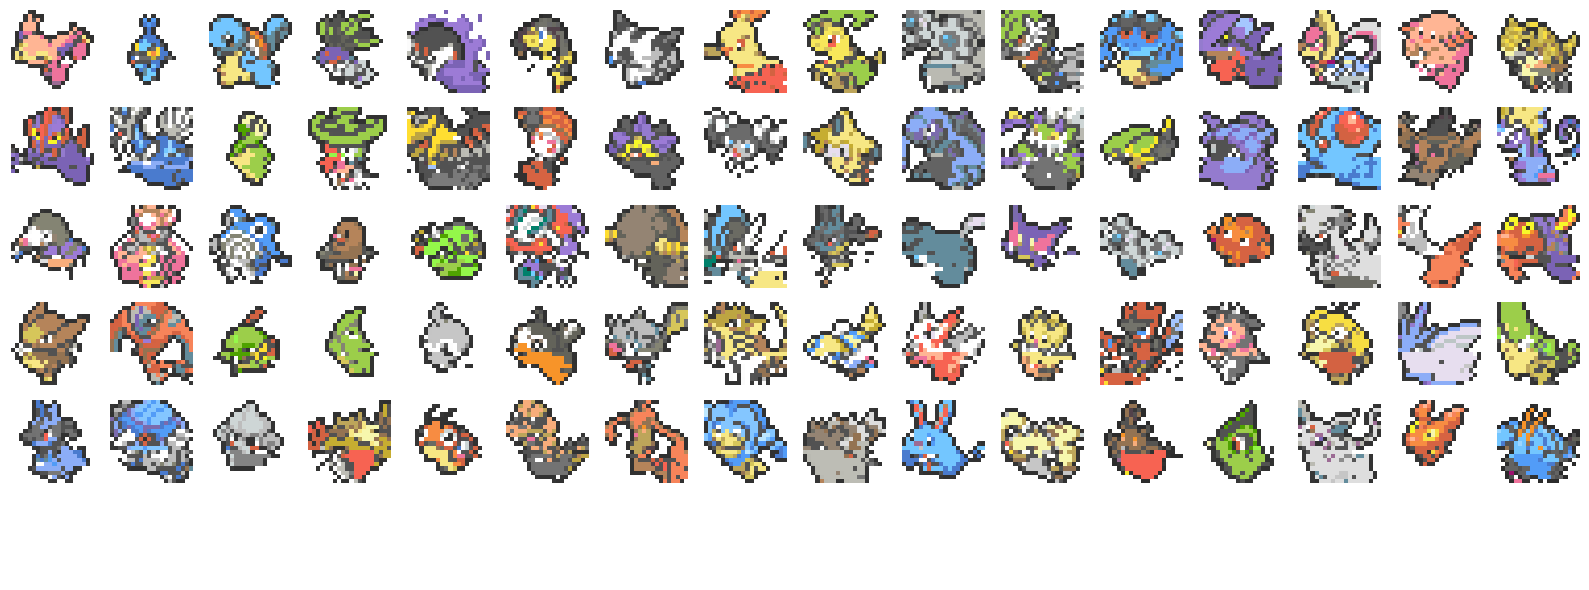

In [32]:
# Visualize generated test images
predicted_images = [pixel_to_image(sequence, colormap) for sequence in results]
show_images(predicted_images)